# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [22]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
import datetime
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

lets have a look at the raw data

In [23]:
portfolio['duration'] = portfolio['duration']*24 #make duration in hours to match transaction table later
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


we can directly see that the channels column contains lists of different ways to advertise, this might be resolved to single columns maybe later

lets have a look at profile data frame

In [24]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


already the head of profile reveals that there are rows with None in gender and income and an unplausible age. we will look into this further

In [25]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


the profile id is unicode encoded and we can convert it to string to not always carry around the u

In [26]:
profile.id = profile.id.apply(str) #convert to non unicode strings

In [27]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


gender and income seem to have a lot of blank values, this might be worth looking at regarding features. maybe people who do not like to give gender or income have certain tendencies. obviously age==118 correlates with gender=None and Income None

lets consider split became_member_on into year,month,day columns - and think about using it later

In [28]:
def int_date_to_YMD(integer_date_YMD):
    date_string = str(integer_date_YMD)
    return date_string[:4], date_string[4:6], date_string[6:]

In [29]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


maximum and average seem to tend a bit high, something worth looking at in a distribution

(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

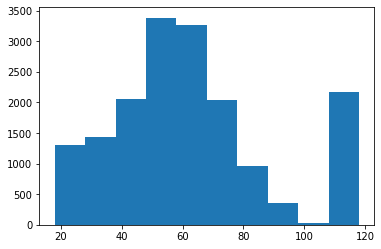

In [30]:
plt.hist(profile.age)

the average of age looks quite high for starbucks customers and the max age is probably outliers which need to be taken care of in either removing or guessing whether they substitute some other value.
first approach lets remove 118

In [31]:
profile = profile[profile.age!=118]

In [32]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [33]:
(profile.id.value_counts()>1).any()

False

checked for double ids in dataset - obviously none

(array([1731., 1707., 2234., 2210., 2345., 1435., 1215.,  990.,  498.,
         460.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

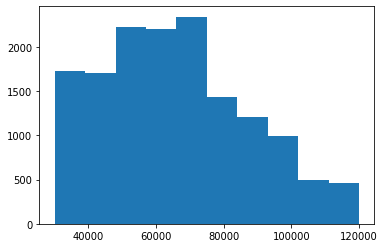

In [34]:
plt.hist(profile.dropna()['income'])

now a look onto transcript

In [35]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


obiously no nan values in the dataset

In [36]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


we can already see that there is a nested information in the value column of transcript. lets have a look into what are the unique values there 

In [37]:
transcript.iloc[24532]

person                     94de646f7b6041228ca7dec82adb97d2
event                                       offer completed
value     {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
time                                                     30
Name: 24532, dtype: object

the value column contains nested information, we should split it up into separate columns

In [38]:
possible_keys = transcript['value'].apply(lambda x: str(list(x.keys())))
possible_keys.value_counts()

['amount']                138953
['offer id']              134002
['offer_id', 'reward']     33579
Name: value, dtype: int64

In [39]:
[str(item) for item in list(transcript.event.unique())] #look at the unique non unicode strings

['offer received', 'offer viewed', 'transaction', 'offer completed']

create separate columns for offer id, amount and reward independant of 'offer_id' or 'offer id'

In [40]:
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0] if 'offer' in str(list(x.keys())[0]) else None)
transcript['amount'] = transcript.value.apply(lambda x: list(x.values())[0] if (list(x.keys())[0])==u'amount' else None)
transcript['reward'] = transcript.value.apply(lambda x: list(x.values())[1] if len(x.keys())==2 else None)
transcript.drop('value',axis=1,inplace=True)

how about the distribution of the data

we see quite many outliers regarding extremely high spendings. we might consider excluding these if models cannot handle it correctly

{'whiskers': [<matplotlib.lines.Line2D at 0x7f38c6183f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f38c61887b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f38c6183d68>],
 'medians': [<matplotlib.lines.Line2D at 0x7f38c6188dd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f38c618c278>],
 'means': []}

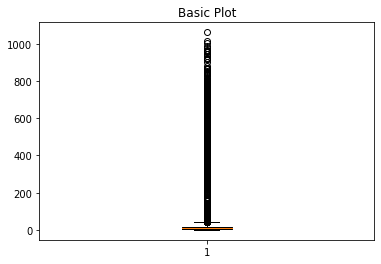

In [41]:
data = transcript[transcript['amount']>0]['amount'].dropna().values.squeeze()
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)

unfortunately there is no information in the transcript table about when an informational offer is completed. for a compensation we will proceed as follows. 
- so far for all other offers there is a **offer received**, **offer viewed** and **offer completed** entry. we will enrich the table by a calculated completion row for valid data points of informational offer completed
- first we sort the data frame for person and continue to work on a copy - adding some helper columns as offer_type
- excluding the rows we dont need for computation: only keep transactions and informational offers viewed
- by shifting event and person columns we make sure we only process rows that belong together. we compare the shifted rows with the original entries in a row and decide whether a record is to be kept or not
- by logical combination of the keep_* columns we have created a criteria a data frame that holds an informational offer followed by the nearest transaction
- we replace **transaction** in the event column by **offer_id** from the previous row to match the row entries from the original transcript table
- now we will check if the time of the nearest transaction is still within the duration period allowed for the informational offer
- setting **amount** and **offer_type** colmn to **np.nan** and **informational** resectively to match the original transcript table format
- reducint the amount of columns to the ones necessary

In [42]:
def lookup_dictionary(look_up_df,search, result):
    '''
    function to create a lookup dictionary between search and result for example offer id -> offer type
    
    '''
    temp_df = look_up_df.copy()
    dic= dict(zip(temp_df[search],temp_df[result]))
    dic[None] = None
    return dic

create a dictionary that holds the information necessary for translating an offer id to an offer type

In [43]:
look_up_offer_type = lookup_dictionary(portfolio,'id','offer_type' )

now we sort the transcript for person and time and enrich it with the offer_type

In [44]:
transcript.head(2)

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [45]:
transcript.sort_values(['person','time'],inplace=True)
trans_enriched = transcript.copy()

# create new column offer_type
trans_enriched['offer_type'] = trans_enriched['offer_id'].apply(lambda x:look_up_offer_type[x]) 



In [46]:
trans_enriched.head(2)

,person,event,time,offer_id,amount,reward,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational


## evaluate time deltas until completion

for later feature engineering we would like to know how much time passed between the different events regarding offers (received, viewed, completed). this is the target of this chapter. unfortunately informational offer does not have an offer completed timestamp in the transaction data. this is the first goal to creat this status.  

for this we first set x hours as duration a customer needs to make a transaction after viewing an informational offer and being within the offer-duration after receiving the offer

In [47]:
manual = 1
hrs_to_complete_informational_offer = 24

if manual:
    duration = hrs_to_complete_informational_offer
else:
    duration = trans['offer_id'].apply(lambda x: lookup_duration[x])

In [48]:
# select only rows with informational offers or transactions
inf_trans = trans_enriched[(trans_enriched['offer_type']=='informational')|(trans_enriched['offer_type'].isnull())].copy()
print(len(inf_trans))

# 
# trans = trans[(trans['event']=='offer received')|(trans['event']=='offer viewed')|(trans['event']=='transaction')]
# print(len(trans))

# by the following shifting operations we create a dataset that contains only an alternation of transactions and the corresponding offer views of informational offers.
# the up-shift as well as the down-shift can lead to overlapping of 'person' id's which dont match and thus have to be excluded
inf_trans['connected_transaction_down_shift'] = (inf_trans['event']=='transaction') & (inf_trans['event'].shift(1)=='offer viewed') & (inf_trans['person']==inf_trans['person'].shift(1))
inf_trans['connected_transaction_up_shift'] = (inf_trans['event']=='offer viewed') & (inf_trans['event'].shift(-1)=='transaction') & (inf_trans['person']==inf_trans['person'].shift(-1))
# trans['person_shift'] = trans['person'].shift(-1)
inf_trans = inf_trans[inf_trans['connected_transaction_down_shift'] | inf_trans['connected_transaction_up_shift']]



165019


check if time between offer received and transaction completed is within duration  
a time can be set as default from the portolio data frame corresponding to each informational offer or chosen manually. 

In [49]:
inf_trans.head(3)

,person,event,time,offer_id,amount,reward,offer_type,connected_transaction_down_shift,connected_transaction_up_shift
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True
89291,0009655768c64bdeb2e877511632db8f,transaction,228,None,22.16,NaN,None,True,False
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational,False,True


In [50]:
# here we actually set the offer_id of the informational offer to the value of the offer_viewed at the position right above the transaction.
# with this we are allowed create the offer_completed event for informational offer and append it to the initial transaction data frame
inf_trans.loc[inf_trans['offer_id'].isnull(),'offer_id'] = inf_trans['offer_id'].shift(1)

In [51]:
inf_trans.head(3)

,person,event,time,offer_id,amount,reward,offer_type,connected_transaction_down_shift,connected_transaction_up_shift
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN,None,True,False
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational,False,True


we see, the transaction event holds the offer_id now.  
we can rename the event typ to offer_completed_simulated for now and remove the helper columns as well as the rows that do not contain the simulated completed offers. then we can concat it to the original transcript datafame

In [52]:
inf_trans.drop(['connected_transaction_down_shift','connected_transaction_up_shift'],axis=1,inplace=True)
inf_trans.loc[inf_trans['event']=='transaction','event'] = 'offer completed sim'
inf_trans = inf_trans[inf_trans.event == 'offer completed sim' ]
inf_trans['offer_type'] = inf_trans['offer_id'].apply(lambda x:look_up_offer_type[x]) 
inf_trans.loc[inf_trans['event']=='offer completed sim','amount'] = np.nan
inf_trans.loc[inf_trans['event']=='offer completed sim','reward'] = 0

In [53]:
print(len(inf_trans))
inf_trans.head(3)

9083


,person,event,time,offer_id,amount,reward,offer_type
89291,0009655768c64bdeb2e877511632db8f,offer completed sim,228,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,informational
168412,0009655768c64bdeb2e877511632db8f,offer completed sim,414,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational
47805,0011e0d4e6b944f998e987f904e8c1e5,offer completed sim,132,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational


In [54]:
print('total length transcript: {} \ntotal length of offers created: {}'.format(len(trans_enriched),len(trans_enriched[(trans_enriched['event']=='offer received')])))
trans_enriched.head()

total length transcript: 306534 
total length of offers created: 76277


,person,event,time,offer_id,amount,reward,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,228,None,22.16,NaN,None
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational


concatenation of simulated offer completed with original enriched transscript data. keep in mind that we still need to evaluate whether the duration where the completen was presumably done might fall out of the validity period still which will be checked later

In [55]:
# concat trans_enriched with inf_trans frame
trans_with_sim = pd.concat([trans_enriched,inf_trans],axis=0)
trans_with_sim

,person,event,time,offer_id,amount,reward,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,228,None,22.16,NaN,None
113605,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational
...,...,...,...,...,...,...,...
221740,ffecb1f8543f4bf7bade023de366d6bf,offer completed sim,510,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,informational
108775,fff0f0aac6c547b9b263080f09a5586a,offer completed sim,318,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational
294474,fff0f0aac6c547b9b263080f09a5586a,offer completed sim,660,3f207df678b143eea3cee63160fa8bed,NaN,0.0,informational
233588,fff3ba4757bd42088c044ca26d73817a,offer completed sim,540,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,informational


In [56]:
merge_temp =  pd.merge(trans_with_sim[trans_with_sim['offer_id'].isnull()==False],
                 portfolio[['id','duration']],
                 left_on='offer_id', right_on='id', how='left').drop('id',axis=1)

# retrieve the lost rows where the id is nan and combine it with the merged df
trans_with_sim = pd.concat([trans_with_sim[trans_with_sim['offer_id'].isnull()],merge_temp],axis=0).sort_values(['person','time'])


In [57]:
len(trans_with_sim)

315617

In [58]:
trans_with_sim.head(4)

,person,event,time,offer_id,amount,reward,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,72.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,72.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,None,22.16,NaN,None,NaN
167581,0009655768c64bdeb2e877511632db8f,offer completed sim,228,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,informational,72.0


In [59]:
# VIEWS
df_temp_view = pd.merge(trans_with_sim[trans_with_sim['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 trans_with_sim[trans_with_sim['event'] == 'offer viewed'][['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

#keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_view = df_temp_view[~(df_temp_view['time_viewed'] < df_temp_view['time_received'])] 

# now that all values are removed where time viewed is smaller than time received duplicates can be removed
df_temp_view.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True)

# this handles the edgecase where a new offer is received and viewed and an older offer of the same type has never been viewed
# nevertheless it can still happen that an offer is viewed very long after having it received
df_temp_view.drop_duplicates(['person','offer_id','time_viewed'],keep='last',inplace=True) 

In [60]:
df_temp_view

,person,offer_id,time_received,time_viewed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN
...,...,...,...,...
95310,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,174.0
95311,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0
95315,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,414.0
95317,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,534.0


In [61]:
# COMPLETIONS
df_temp_completed =  pd.merge(trans_with_sim[trans_with_sim['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 trans_with_sim[(trans_with_sim['event'] == 'offer completed')|(trans_with_sim['event'] == 'offer completed sim')][['person', 'offer_id', 'time','reward']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_completed'])


df_temp_completed = df_temp_completed[~(df_temp_completed['time_completed'] < df_temp_completed['time_received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_completed.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

# df_sample = df_temp_completed[df_temp_completed['person']==example_customer].copy()
# df_sample
df_temp_completed.drop_duplicates(['person','offer_id','time_completed'],keep='last',inplace=True) 

In [62]:
df_temp_joined = pd.merge(df_temp_view,df_temp_completed,how='left',on=['person','offer_id','time_received'])
df_temp_joined

,person,offer_id,time_received,time_viewed,time_completed,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,228.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,414.0,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,5.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,2.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
...,...,...,...,...,...,...
71873,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,174.0,198.0,5.0
71874,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0,384.0,2.0
71875,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,414.0,414.0,2.0
71876,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,534.0,504.0,5.0


In [63]:
df_temp_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71878 entries, 0 to 71877
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   person          71878 non-null  object 
 1   offer_id        71878 non-null  object 
 2   time_received   71878 non-null  int64  
 3   time_viewed     57725 non-null  float64
 4   time_completed  40934 non-null  float64
 5   reward          40934 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.8+ MB


we are not interested in datasets, where the customer viewed the offer after it was completed already for example customer ```ffff82501cea40309d5fdd7edcca4a07``` did so with offer ```9b98b8c7a33c4b65b9aebfe6a799e6d9```  

join the duration and potential reward to the data frame

In [64]:
df_temp_joined = df_temp_joined[~(df_temp_joined['time_viewed']>df_temp_joined['time_completed'])]
df_temp_joined

,person,offer_id,time_received,time_viewed,time_completed,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,228.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,414.0,0.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,NaN
...,...,...,...,...,...,...
71870,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,408,510.0,516.0,5.0
71872,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,0,6.0,60.0,2.0
71873,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,174.0,198.0,5.0
71874,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0,384.0,2.0


In [65]:
df_temp_joined[df_temp_joined['person']=='00116118485d4dfda04fdbaba9a87b5c']

,person,offer_id,time_received,time_viewed,time_completed,reward
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,NaN


now we can merge again the enriched original data with the 

In [66]:
# df1 = pd.DataFrame({'person':[1,2,3,4],'offer':[4,5,6,22],'time':[5,2,44,1],'anything':[5,5,66,5]})
# df2 = pd.DataFrame({'person':[1,1,1,1,2,2,3,3],'offer':[4,5,6,4,5,6,5,6],'c':[8,7,6,555,5,4,3,2]})

In [67]:
# df1

In [68]:
# df2

In [69]:
# pd.merge(df1,df2,on=['person','offer'],how='left')

In [70]:
# transcript[transcript.person=='0009655768c64bdeb2e877511632db8f']

In [71]:
# trans_with_sim[trans_with_sim.person=='0009655768c64bdeb2e877511632db8f']

In [72]:
print('trans_with_sim: ',len(trans_with_sim))
merge_orig_view_1 = pd.merge(trans_with_sim.loc[trans_with_sim.event=='transaction',['person','time','amount']], 
                             df_temp_joined,
                             left_on=['person','time'],
                             right_on=['person','time_received'],
                             how='outer')
print('merge_orig_view_1: ',len(merge_orig_view_1))

trans_with_sim:  315617
merge_orig_view_1:  202618


In [73]:
# df_temp_joined[df_temp_joined['person']=='ffff82501cea40309d5fdd7edcca4a07']

In [74]:
# transcript[transcript['person']=='ffff82501cea40309d5fdd7edcca4a07']

In [75]:
# df = pd.DataFrame(np.random.randint(low=0, high=10, size=(1000000)), columns=['column_1'])
# conditions = [
#     (df['column_1'] > 5),
#     (df['column_1'] <= 5) & (df['column_1'] > 0),
#     (df['column_1'] == 0)]
# choices = ['high','low','null']

# df['column_2'] = np.select(conditions, choices, default='null')

In [76]:
merge_orig_view_1.loc[merge_orig_view_1['time'].isnull()==True,'time'] = merge_orig_view_1['time_received']

In [77]:
merge_orig_view_1[merge_orig_view_1['person']=='00116118485d4dfda04fdbaba9a87b5c']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward
8,00116118485d4dfda04fdbaba9a87b5c,294.0,0.70,NaN,NaN,NaN,NaN,NaN
9,00116118485d4dfda04fdbaba9a87b5c,456.0,0.20,NaN,NaN,NaN,NaN,NaN
10,00116118485d4dfda04fdbaba9a87b5c,474.0,3.19,NaN,NaN,NaN,NaN,NaN
138955,00116118485d4dfda04fdbaba9a87b5c,168.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,168.0,216.0,NaN,NaN
138956,00116118485d4dfda04fdbaba9a87b5c,576.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,576.0,630.0,NaN,NaN


In [78]:
merge_orig_view_1 = pd.merge(merge_orig_view_1,
        portfolio[['id','reward','duration','offer_type']].rename(columns={'reward':'potential_reward'}),
        left_on='offer_id',
        right_on='id',
        how='left')
merge_orig_view_1.drop('id',axis=1,inplace=True)

we set the duration for informational offer to the defined value

In [79]:
merge_orig_view_1.loc[merge_orig_view_1['offer_type'] == 'informational','info_valid_after_view'] = duration

check customer

In [80]:
merge_orig_view_1[merge_orig_view_1['person']=='fff3ba4757bd42088c044ca26d73817a']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,info_valid_after_view
138904,fff3ba4757bd42088c044ca26d73817a,6.0,20.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138905,fff3ba4757bd42088c044ca26d73817a,24.0,23.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138906,fff3ba4757bd42088c044ca26d73817a,60.0,21.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138907,fff3ba4757bd42088c044ca26d73817a,96.0,14.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138908,fff3ba4757bd42088c044ca26d73817a,168.0,22.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138909,fff3ba4757bd42088c044ca26d73817a,192.0,18.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138910,fff3ba4757bd42088c044ca26d73817a,222.0,10.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138911,fff3ba4757bd42088c044ca26d73817a,318.0,15.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138912,fff3ba4757bd42088c044ca26d73817a,528.0,17.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138913,fff3ba4757bd42088c044ca26d73817a,540.0,388.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


for informational offers we have to eliminate the invalid ones - meaning the ones that are completed or viewed after the chosen duration of validity and the ones

In [81]:
merge_orig_view_1[(merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_completed'].isnull()==False)]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,info_valid_after_view
289,00c6035df45840038a72766c6d27a0db,336.0,23.07,3f207df678b143eea3cee63160fa8bed,336.0,336.0,336.0,0.0,0.0,96.0,informational,24.0
511,012ee55a90bd4d969b0d0cdfaffdf6ab,168.0,1.51,5a8bc65990b245e5a138643cd4eb9837,168.0,180.0,192.0,0.0,0.0,72.0,informational,24.0
1162,0231c913a51e420783be6bdeb75aa842,336.0,1.50,5a8bc65990b245e5a138643cd4eb9837,336.0,342.0,396.0,0.0,0.0,72.0,informational,24.0
1510,02e6dbe7c694441a88f9160b6b0e1a35,408.0,14.82,5a8bc65990b245e5a138643cd4eb9837,408.0,414.0,420.0,0.0,0.0,72.0,informational,24.0
1600,03118ab70a404fada1a433cd6abaa491,168.0,10.98,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,168.0,0.0,0.0,72.0,informational,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
202584,ffecb1f8543f4bf7bade023de366d6bf,0.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,78.0,510.0,0.0,0.0,72.0,informational,24.0
202595,fff0f0aac6c547b9b263080f09a5586a,168.0,NaN,3f207df678b143eea3cee63160fa8bed,168.0,288.0,318.0,0.0,0.0,96.0,informational,24.0
202597,fff0f0aac6c547b9b263080f09a5586a,576.0,NaN,3f207df678b143eea3cee63160fa8bed,576.0,636.0,660.0,0.0,0.0,96.0,informational,24.0
202602,fff3ba4757bd42088c044ca26d73817a,504.0,NaN,5a8bc65990b245e5a138643cd4eb9837,504.0,540.0,540.0,0.0,0.0,72.0,informational,24.0


In [82]:
# set the ones to nan which are too late completions. too late means they are not within validity period taken from portfolio data set as well as not within the chosen
# validity period (example no transaction within 24h after view)
condition =( merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_received']+merge_orig_view_1['duration'] < merge_orig_view_1['time_completed'])
merge_orig_view_1.loc[condition,'time_completed'] = np.nan

# set the ones to nan which have not been viewed before completion
condition =( merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_viewed']+merge_orig_view_1['info_valid_after_view'] < merge_orig_view_1['time_completed'])
merge_orig_view_1.loc[condition,'time_completed'] = np.nan
merge_orig_view_1.drop('info_valid_after_view',axis=1,inplace=True)

In [83]:
merge_orig_view_1[merge_orig_view_1['person']=='ffecb1f8543f4bf7bade023de366d6bf'] # should mark invalid first offer

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type
138873,ffecb1f8543f4bf7bade023de366d6bf,510.0,3.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138874,ffecb1f8543f4bf7bade023de366d6bf,588.0,6.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138875,ffecb1f8543f4bf7bade023de366d6bf,600.0,0.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202584,ffecb1f8543f4bf7bade023de366d6bf,0.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,78.0,NaN,0.0,0.0,72.0,informational
202585,ffecb1f8543f4bf7bade023de366d6bf,168.0,NaN,2906b810c7d4411798c6938adc9daaa5,168.0,174.0,NaN,NaN,2.0,168.0,discount
202586,ffecb1f8543f4bf7bade023de366d6bf,336.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,360.0,NaN,NaN,5.0,240.0,discount
202587,ffecb1f8543f4bf7bade023de366d6bf,408.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,408.0,NaN,NaN,5.0,168.0,bogo
202588,ffecb1f8543f4bf7bade023de366d6bf,504.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,504.0,708.0,NaN,NaN,5.0,240.0,discount


In [84]:
merge_orig_view_1[(merge_orig_view_1['offer_type']=='informational')&(merge_orig_view_1['time_completed'].isnull()==False)]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type
289,00c6035df45840038a72766c6d27a0db,336.0,23.07,3f207df678b143eea3cee63160fa8bed,336.0,336.0,336.0,0.0,0.0,96.0,informational
511,012ee55a90bd4d969b0d0cdfaffdf6ab,168.0,1.51,5a8bc65990b245e5a138643cd4eb9837,168.0,180.0,192.0,0.0,0.0,72.0,informational
1510,02e6dbe7c694441a88f9160b6b0e1a35,408.0,14.82,5a8bc65990b245e5a138643cd4eb9837,408.0,414.0,420.0,0.0,0.0,72.0,informational
1600,03118ab70a404fada1a433cd6abaa491,168.0,10.98,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,168.0,0.0,0.0,72.0,informational
1744,03533ca5a4244ca3ac48b9c8ccba8332,576.0,3.41,3f207df678b143eea3cee63160fa8bed,576.0,624.0,648.0,0.0,0.0,96.0,informational
...,...,...,...,...,...,...,...,...,...,...,...
202541,ffb7fc8ad0594248a49e210ff0217c2d,0.0,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,54.0,60.0,0.0,0.0,72.0,informational
202581,ffeaa02452ef451082a0361c3ca62ef5,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,168.0,198.0,216.0,0.0,0.0,72.0,informational
202582,ffeaa02452ef451082a0361c3ca62ef5,408.0,NaN,5a8bc65990b245e5a138643cd4eb9837,408.0,420.0,420.0,0.0,0.0,72.0,informational
202597,fff0f0aac6c547b9b263080f09a5586a,576.0,NaN,3f207df678b143eea3cee63160fa8bed,576.0,636.0,660.0,0.0,0.0,96.0,informational


In [85]:
merge_orig_view_1.sort_values(['person','time','offer_id'],inplace=True)

determine which channels are available in portfolio channels column

In [86]:
channel_list=[]
for channels in portfolio.channels:
    for channel in channels:
        channel_list.append(channel)
channel_list = list(set(channel_list))
channel_list

['email', 'mobile', 'web', 'social']

create one-hot-encoding for the determined channels

In [87]:
for i, row in portfolio.iterrows():
    for channel in channel_list:
        if channel in row.channels:
            portfolio.loc[i,channel]=1
        else:
            portfolio.loc[i,channel]=0


In [88]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,0.0,1.0
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,1.0,0.0
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,1.0,0.0


In [89]:
merge_orig_view_2 = pd.merge(merge_orig_view_1,
                             portfolio[['difficulty','id','mobile','email','social','web']], 
                             how='left',
                             left_on='offer_id',
                             right_on='id').drop('id',axis=1)

have a look at the final dataset where offers occur

In [90]:
merge_orig_view_2[merge_orig_view_2['offer_id'].isnull()==False]

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,difficulty,mobile,email,social,web
0,0009655768c64bdeb2e877511632db8f,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,0.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,336.0,NaN,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,0.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
6,0009655768c64bdeb2e877511632db8f,576.0,10.27,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,2.0,2.0,168.0,discount,10.0,1.0,1.0,0.0,1.0
10,00116118485d4dfda04fdbaba9a87b5c,168.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,168.0,216.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
14,00116118485d4dfda04fdbaba9a87b5c,576.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,576.0,630.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,fffad4f4828548d1b5583907f2e9906b,408.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,408.0,510.0,516.0,5.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
202599,ffff82501cea40309d5fdd7edcca4a07,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0.0,6.0,60.0,2.0,2.0,240.0,discount,10.0,1.0,1.0,1.0,1.0
202603,ffff82501cea40309d5fdd7edcca4a07,168.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0,174.0,198.0,5.0,5.0,240.0,discount,20.0,0.0,1.0,0.0,1.0
202609,ffff82501cea40309d5fdd7edcca4a07,336.0,NaN,2906b810c7d4411798c6938adc9daaa5,336.0,354.0,384.0,2.0,2.0,168.0,discount,10.0,1.0,1.0,0.0,1.0


In [91]:
merge_orig_view_2[merge_orig_view_2['person']=='00116118485d4dfda04fdbaba9a87b5c']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,offer_type,difficulty,mobile,email,social,web
10,00116118485d4dfda04fdbaba9a87b5c,168.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,168.0,216.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
11,00116118485d4dfda04fdbaba9a87b5c,294.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,00116118485d4dfda04fdbaba9a87b5c,456.0,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,00116118485d4dfda04fdbaba9a87b5c,474.0,3.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,00116118485d4dfda04fdbaba9a87b5c,576.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,576.0,630.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0


mark transactions as offer_type ```transaction```

In [92]:
merge_orig_view_2.loc[merge_orig_view_2['offer_type'].isnull()==True,'offer_type'] = 'transaction' 

In [93]:
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [94]:
# create one hot encoded male-female columns. Others is linear dependant and shouldnt be a separate column
profile=pd.concat([profile, pd.get_dummies(profile['gender'])],axis=1)#.drop('O',axis=1)],axis=1)
profile

,gender,age,id,became_member_on,income,F,M,O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,1,0
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,0,1,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0,1,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1,0,0


In [95]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

In [96]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))


In [97]:
base_time = profile['became_member_on'].min()
profile['member_since_month'] = profile.apply(lambda x:month_diff(x['became_member_on'],base_time),axis = 1)
profile.drop(['became_member_on'],axis=1,inplace=True)

In [98]:
merge_orig_view_3 = pd.merge(merge_orig_view_2,
        profile,
        left_on='person',
        right_on='id',
        how='left').drop('id',axis=1)

In [99]:
transactions =  merge_orig_view_3

as a cleansing step in the beginning we removed all customers that dont have proper values for age, income, gender. we have to repeat here for the transaction data frame

In [114]:
transactions = transactions[transactions['gender'].isnull()==False]

write transactions to file

In [115]:
transactions.to_csv('transactions.csv',index=False)

In [116]:
len(transactions[transactions.amount>50])/len(transactions)

0.0035876544451709166

In [117]:
transcript[transcript['person']=='004b041fbfe44859945daa2c7f79ee64']

,person,event,time,offer_id,amount,reward
20790,004b041fbfe44859945daa2c7f79ee64,transaction,18,None,25.62,NaN
56591,004b041fbfe44859945daa2c7f79ee64,offer received,168,3f207df678b143eea3cee63160fa8bed,NaN,NaN
124555,004b041fbfe44859945daa2c7f79ee64,transaction,336,None,24.30,NaN
133435,004b041fbfe44859945daa2c7f79ee64,transaction,354,None,21.11,NaN
145895,004b041fbfe44859945daa2c7f79ee64,transaction,390,None,19.48,NaN
204926,004b041fbfe44859945daa2c7f79ee64,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
219332,004b041fbfe44859945daa2c7f79ee64,offer viewed,510,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
231080,004b041fbfe44859945daa2c7f79ee64,transaction,534,None,27.92,NaN
231081,004b041fbfe44859945daa2c7f79ee64,offer completed,534,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
248476,004b041fbfe44859945daa2c7f79ee64,offer received,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [118]:
transactions[transactions['person']=='004b041fbfe44859945daa2c7f79ee64']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,...,email,social,web,gender,age,income,F,M,O,member_since_month
95,004b041fbfe44859945daa2c7f79ee64,18.0,25.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0
96,004b041fbfe44859945daa2c7f79ee64,168.0,NaN,3f207df678b143eea3cee63160fa8bed,168.0,NaN,NaN,NaN,0.0,96.0,...,1.0,0.0,1.0,F,55.0,74000.0,1.0,0.0,0.0,58.0
97,004b041fbfe44859945daa2c7f79ee64,336.0,24.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0
98,004b041fbfe44859945daa2c7f79ee64,354.0,21.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0
99,004b041fbfe44859945daa2c7f79ee64,390.0,19.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0
100,004b041fbfe44859945daa2c7f79ee64,504.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,504.0,510.0,534.0,5.0,5.0,120.0,...,1.0,1.0,1.0,F,55.0,74000.0,1.0,0.0,0.0,58.0
101,004b041fbfe44859945daa2c7f79ee64,534.0,27.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0
102,004b041fbfe44859945daa2c7f79ee64,576.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,576.0,576.0,714.0,2.0,2.0,240.0,...,1.0,1.0,1.0,F,55.0,74000.0,1.0,0.0,0.0,58.0
103,004b041fbfe44859945daa2c7f79ee64,714.0,19.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,55.0,74000.0,1.0,0.0,0.0,58.0


In [ ]:
transcript[transcript['person']=='00116118485d4dfda04fdbaba9a87b5c']

In [ ]:


# create a column for the durations that apply to an offer - either manually assigned or by the portfolio dataset
trans['duration'] = duration

# bringing the time of the nearest transaction up to the corresponding offer viewed status
trans['time_pot_complete'] = trans['time'].shift(-1)

# calculations for determining if the nearest transaction was within a valid offer period
trans['within_time'] = (trans['time'] - trans['time_pot_complete'])<=trans['duration']
trans = trans[(trans['event']=='transaction') & (trans['within_time']==True)].copy()

# setting values to default
trans['amount'] = np.nan
trans['reward'] = 0
trans['offer_type'] = np.nan

# having all computations finished we can add the label offer completed as it is available for the other offer types as well
trans['event'] = 'offer completed'

# only keep the relevant columns
informal_transaction_to_offer_completed = trans[['person','event','time','offer_id','amount','reward','offer_type']]

In [ ]:
# joining the original transcript data with the newly generated data regarding informational offers 
transcript = pd.concat([transcript,informal_transaction_to_offer_completed],axis=0)
transcript.sort_values(['time','person','amount'],inplace=True)
transcript.head()

check, what are customers with a high order behaviour

In [ ]:
multi_order = transcript.groupby('person').count()
multi_order.sort_values('event',ascending=False,inplace=True)
multi_order.head()

chose a sample customer for looking into one example behaviour

In [ ]:
example_customer = multi_order.index[0]
transcript[transcript['person']==example_customer]

create a temporary dataframe containing all times of **offer received** and **offer viewed**. this will be usefull for feature engineering. Due to the merge there will be data in the result where **offer viewed** will be before **offer received**. these must be removed. once this is done removing duplicate values in the time received column will make sure only adjacent events of offer received and offer viewed are counted into one event

In [ ]:
# df_temp_view = pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer_id', 'time']],
#                  transcript[transcript['event'] == 'offer viewed'][['person', 'offer_id', 'time']],
#                  on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# #keep entries that are equal meaning the customer checked the offer quite quickly
# df_temp_view = df_temp_view[~(df_temp_view['time_viewed'] < df_temp_view['time_received'])] 

# # now that all values are removed where time viewed is smaller than time received duplicates can be removed
# df_temp_view.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True)

# # this handles the edgecase where a new offer is received and viewed and an older offer of the same type has never been viewed
# # nevertheless it can still happen that an offer is viewed very long after having it received
# df_temp_view.drop_duplicates(['person','offer_id','time_viewed'],keep='last',inplace=True) 

In [ ]:
df_temp_view[df_temp_view['time_viewed']<df_temp_view['time_received']]

<- no inconsistancies

the same approach as before is chosen for creating a dataset considerung the time of offer completed and the reward information

In [ ]:
df_temp_completed =  pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 transcript[transcript['event'] == 'offer completed'][['person', 'offer_id', 'time','reward']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_completed'])


df_temp_completed = df_temp_completed[~(df_temp_completed['time_completed'] < df_temp_completed['time_received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_completed.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

# df_sample = df_temp_completed[df_temp_completed['person']==example_customer].copy()
# df_sample
df_temp_completed.drop_duplicates(['person','offer_id','time_completed'],keep='last',inplace=True) 

In [ ]:
df_temp_completed[df_temp_completed['time_completed']<df_temp_completed['time_received']]

<- no inconsistancies
now the newly created temporary frames will be merged

In [ ]:
customer_offers = pd.merge(df_temp_view,
                           df_temp_completed,
                          on=['person','offer_id','time_received'],
                          how='left')

last check needs to be, whether there are data which have a time completed being smaller time viewed. as expected there are data where the customer completes the offer but has never viewed it.

In [ ]:
customer_offers.sort_values('person')

In [ ]:
#to later also use the informational offers as possible features we assume, as stated in the task, that a customer is influenced by the information for the duration time given in the portfolio dataset for each informational offer after he or she has *received* the offer. i add that he can only be influenced if he saw the offer which leads to the following processing

# if the time viewed is larger than time completed the customer cannot have been influenced by the info offer thus will be have a time completed set to nan
customer_offers.loc[(customer_offers['time_completed'] < customer_offers['time_viewed']),'time_completed'] = None 

information_offers = [str(x) for x in list(portfolio[portfolio['offer_type']=='informational']['id'])]
information_offers
for offer_id in information_offers: #two informational offers are present in portfolio
    
#     # now if the time viewed is larger than time completed the customer cannot have been influenced by the info offer thus will be have a time completed set to nan
#     customer_offers.loc[(customer_offers['offer_id']==offer_id) & (customer_offers['time_completed'] < customer_offers['time_viewed']),'time_completed'] = None   
    
    #the reward is generally 0 on info offers but should be nan if there was not even a view or a view after the validity 
    customer_offers.loc[customer_offers['offer_id']==offer_id,'reward'] = 0 * customer_offers['time_completed'] #keeping nan as nan and others to 0

now we have a dataframe that holds information about the behaviour of one customer regarding the offers he or she made. we have listed the time stamps when he or she received,viewed or completed the offer

creating further information: here we calculate the deltas bewtween times

In [ ]:
customer_offers['delta_viewed_received'] = customer_offers['time_viewed'] - customer_offers['time_received']
customer_offers['delta_completed_received'] = customer_offers['time_completed'] - customer_offers['time_received']
customer_offers['delta_completed_viewed'] = customer_offers['time_completed'] - customer_offers['time_viewed']

looking into one specific customer the values seem plausible. one can see interesting cases
- first row shows the infomation offer (reward == 0)
- second row has a regular offer with reward
- third row shows the case where the offer was read after completion only

In [ ]:
sample2 = customer_offers[customer_offers['person']=='a5a6ef2b78a04ddc9f374dd7c7f60bff'].copy()
sample2

following data frame ```customer_offers``` represents how much time a person took to view or complete offers. if similar offers were sent to the same person it is the sum of times spent. for this we pivot the table for person in rows and offers in columns

In [ ]:
offer_times_pivot = pd.pivot_table(customer_offers, index=['person'], columns=['offer_id'], aggfunc='mean')
offer_times_pivot.columns = offer_times_pivot.columns.swaplevel(0,1)
offer_times_pivot.sort_index(level=0,axis=1,inplace=True)
#customer_offers_pivot=customer_offers_pivot.droplevel(0,axis=1)
offer_times_pivot.head()

one more feature could be, how much money a person spent after he or she saw the offer until completing the offer

In [ ]:
customer_offers['offer_type'] = customer_offers['offer_id'].apply(lambda x: look_up_offer_type[x])

now we can create a data frame with person in rows and their offer counts in columns. after pivoting this data frame we will be able to do peform feature extraction

In [ ]:
# aggregation of the customer_offers data frame to receive only one data frame that has persons in rows and aggregated values in the cells - sums for awards
# or count bogo for the number of bogo offers
offer_counts = customer_offers.groupby(['person','offer_type']).agg({'time_received':'count',
                             'time_viewed':'count',
                              'time_completed':'count',
                             'reward':'sum'}).rename(columns={'time_received':'count_received',
                                                              'time_viewed':'count_viewed',
                                                              'time_completed':'count_completed',
                                                              'reward':'sum_reward'})

offer_counts_pivot = pd.pivot_table(offer_counts,index='person', columns='offer_type',values=['count_received','count_viewed','count_completed','sum_reward'])

# cleanup of column names after transformation
offer_counts_pivot.columns = offer_counts_pivot.columns.swaplevel(0,1)
offer_counts_pivot.sort_index(level=0,axis=1,inplace=True)
offer_counts_pivot.fillna(value=0,inplace=True)
offer_counts_pivot.columns.set_levels(['bogo','discount','informational'],level=0,inplace=True)
offer_counts_pivot.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in offer_counts_pivot.columns] # make one word column header
offer_counts_pivot

analyzing the dataset one could see that offers do overlap - two offers can be started without the first one being completed. to not count amounts double douring that time, we identify overlapping offers and later remove them. 

In [ ]:
def filter_time_range(df_ele,trange):
    if (df_ele['time']>=trange[0]) and (df_ele['time']<=trange[1]):
        return df_ele['amount']
    else:
        return np.nan

In [ ]:
# sample_trans = transcript[transcript['person']=='0cc6e8553c844c02ab525bc466aa569b']
# sample =customer_offers[customer_offers['person']=='0cc6e8553c844c02ab525bc466aa569b']
# sub_group_ranges = list(zip(sample['time viewed'], sample['time completed']))

def overlap(sub_group_ranges):
    valid_ranges = []
    #print(sub_group_ranges)
    for tup in sub_group_ranges:
        if not (np.isnan(np.sum(tup))):
           # print(np.sum(tup))
            valid_ranges.append(tup)
        #    sub_group_ranges.remove(tup)
   # print(valid_ranges)        
    tuple_list =[] 
    if len(valid_ranges)>0:
        for tup in valid_ranges:
            tuple_list.append(np.arange(tup[0],tup[1]))
    
    if len(tuple_list)>0:
        xs = set(tuple_list[0])
        count = len(tuple_list[0])
        for item in tuple_list[1:]:
            xs = xs.union(item)
            count = count + len(item)
    else:
        count = 0
        xs = set()
    if len(xs) < count:
        return 1
    else:
        return 0

In [ ]:
%%time
file_name = 'df_person_money_spent_inc_overlap_informational_retry.pkl'
sub_group_ranges=None
collected_sub_group_ranges = None
#df_person_money_spent=None
if os.path.isfile(file_name):
    df_person_money_spent = pd.read_pickle(file_name)
    print('read file {}'.format(file_name))
else:
    person_list =list(transcript.groupby('person').count().sort_values('event', ascending=False).index)[:]
    person_money_spent = []
    person_money_spent_per_offer=[]
    overlap_list=[]
    for i, person in enumerate(person_list):
        df_offer = pd.DataFrame()
        if i%100==0:
            print(i,' person evaluated')
        offer_list = [str(x) for x in list(transcript[transcript['person']==person]['offer_id'].unique())]
        if 'None' in offer_list : offer_list.remove('None')
        person_money_spent_per_offer=[]
        collected_sub_group_ranges=[]
        for offer_id in offer_list:
           # print(offer_id)
            df = transcript.loc[transcript['person']==person].copy()
            sample = customer_offers.loc[(customer_offers['person']==person) & (customer_offers['offer_id']==offer_id)]
            sub_group_ranges = list(zip(sample['time_viewed'], sample['time_completed']))
            collected_sub_group_ranges = collected_sub_group_ranges+sub_group_ranges
            for trange in sub_group_ranges:
                df[str(trange)] = df.apply(lambda x: filter_time_range(x,trange),axis=1)
            dfg_per_offer=df.groupby(['person']).sum()
            sub_result = pd.concat([dfg_per_offer.iloc[:,:3],dfg_per_offer.iloc[:,3:].sum(axis=1)],axis=1)
            sub_result['offer_id'] = offer_id
            
            person_money_spent_per_offer.append(sub_result)
           # print(len(person_money_spent_per_offer))
        if len(offer_list) >0:
            df_person_money_spent_per_offer = pd.concat(person_money_spent_per_offer,axis=0)
            #print(collected_sub_group_ranges)
            overlap_status = overlap(collected_sub_group_ranges)
           # print('overlap: ',overlap_status)
            df_person_money_spent_per_offer['overlap'] = overlap_status
            person_money_spent.append(df_person_money_spent_per_offer)            
    df_person_money_spent = pd.concat(person_money_spent,axis=0)
    df_person_money_spent.rename(columns={0:'spent_in_offer'},inplace=True)
    df_person_money_spent.to_pickle(file_name)
    print('wrote file {}'.format(file_name))

some of the results overlap. this means that more than one offer is active per customer at the same time(viewed and not yet completed). since they are around 10 % of the data they will be excluded. otherwise the amount spent during an offer would be counted multiple times.

In [ ]:
df_person_money_spent

In [ ]:
len(df_person_money_spent[df_person_money_spent['overlap']==1])/len(df_person_money_spent)

following data frame ```df_person_money_spent``` represents how much a single person spent while an offer was active. if similar offers were sent to the same person it is the sum of spendings. to group further we can pivot the table for person in rows and offers in columns or for a less deep analysis by only reward-type in columns

In [ ]:
group_spending = ['offer_id']
group_spending = ['offer_type']
df_person_money_spent=df_person_money_spent[df_person_money_spent['overlap']==0].copy()
df_person_money_spent['offer_type'] = df_person_money_spent['offer_id'].apply(lambda x: look_up_offer_type[x])

df_person_money_spent_pivot = pd.pivot_table(df_person_money_spent, index=['person'], columns=group_spending, aggfunc={'spent_in_offer':'sum'})
df_person_money_spent_pivot.columns = df_person_money_spent_pivot.columns.swaplevel(0,1)
df_person_money_spent_pivot.sort_index(axis=1,  inplace=True)
df_person_money_spent_pivot.fillna(value=0,inplace=True)
# df_person_money_spent_pivot.columns.set_levels(['non rewarded','rewarded'],level=0,inplace=True)
df_person_money_spent_pivot.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_person_money_spent_pivot.columns]
#person_spendings_by_offer=df_person_money_spent_pivot.droplevel(0,axis=1)
df_person_money_spent_pivot

now we can start to build a data frame holding demographic data and data derrived from calculations on how much a customer spends regarding a certain offer
- taking the base profile dataset containing demographic information
- concatenating with information about spendings and rewards per offer
- concatenating with spendings and rewards in general

In [ ]:
profile_for_merge = profile.copy()
profile_for_merge.index = profile_for_merge.id
profile_for_merge.drop('id',axis=1,inplace=True)
profile_for_merge

In [ ]:
amount_spent = transcript.groupby('person').agg({'amount':'sum'})
amount_spent.columns = ['amount_spent_total']

In [ ]:
df_to_combine=[offer_counts_pivot,df_person_money_spent_pivot,amount_spent,profile_for_merge]
                   

joined_part1 = pd.merge(profile_for_merge, offer_counts_pivot, how='inner', left_index=True, right_index=True)
joined_part2 = pd.merge(joined_part1, df_person_money_spent_pivot, how='inner', left_index=True, right_index=True)
customers = pd.merge(joined_part2, amount_spent, how='inner', left_index=True, right_index=True)
customers.sort_index(axis=1,  inplace=True)

#joined = pd.concat(df_to_combine,axis=1, sort=False)
print([len(x) for x in df_to_combine]+[len(customers)])

In [ ]:
customers[customers.index.str.startswith('0cc6e8553c844c02ab525bc466aa569b')]

In [ ]:
customers.sort_values('bogo_spent_in_offer')

In [ ]:
customers.describe()

In [ ]:
customers.to_excel('customers.xlsx')
customers.to_csv('customers.csv')

## KPI s for person
Lets first grab a list of features that come to mind when wanting to analyze the customers behvaiour. 

- count offers received
- count offers viewed
- count transactions
- count offers completed
- total ammount spent
- view_ratio
- transaction_ratio
- completeness_ratio
- ammount spent during offer A
- ammount spent outside offer
- time being customer



checking conversion rate of each offer type

In [ ]:
customers.columns

In [ ]:
cr_bogo = customers['bogo_count_completed'].sum()/customers['bogo_count_received'].sum()
cr_discount = customers['discount_count_completed'].sum()/customers['discount_count_received'].sum()
cr_information = customers['informational_count_completed'].sum()/customers['informational_count_received'].sum()
print(cr_bogo,cr_discount,cr_information)

the high conversion rate of informational offers might be due to the fact that the initial description of the dataset suggests that an informational offer influences the customer for its given duration. this might be too long and can be used as a parameter to tweak later. however the amount spent on informational offers is less then in rewarded offers - roughly half regarding the other offers individually

In [ ]:
sum_bogo = customers['bogo_spent_in_offer'].sum()
sum_discount = customers['discount_spent_in_offer'].sum()
sum_information = customers['informational_spent_in_offer'].sum()
print(sum_bogo,sum_discount,sum_information)

In [ ]:
customers

In [ ]:
customers_bogo = customers[['age','gender','income','became_member_on','amount_spent_total','bogo_count_completed','bogo_count_received','bogo_count_viewed','bogo_spent_in_offer','bogo_sum_reward']]
customers_bogo.to_csv('customers_bogo.csv')

customers_discount = customers[['age','gender','income','became_member_on','amount_spent_total','discount_count_completed','discount_count_received','discount_count_viewed','discount_spent_in_offer','discount_sum_reward']]
customers_discount.to_csv('customers_discount.csv')

customers_informational = customers[['age','gender','income','became_member_on','amount_spent_total','informational_count_completed','informational_count_received','informational_count_viewed','informational_spent_in_offer','informational_sum_reward']]
customers_informational.to_csv('customers_informational.csv')

customers_separate_list = [customers_bogo, customers_discount,customers_informational]

In [ ]:
profile